This notebook is dedicated to studying the phenomenon of double descent in linear models. For neural network (NN) interpretations of the same phenomenon, please see the Double Descent NN (local code) notebook.

Much of this code is taken from the google colab file. Google colab seems faster, but the issues with disconnecting, RAM limits, and runtime have become frustrating.

In [14]:
from tqdm import tqdm

In [15]:
#@title Downloading dependencies

# enabling scikeras. This was necessary for google colab, but may not be required when locally hosting data
#!pip install scikeras

# importing all necessary libraries. Fewer are required for linear models than proper handling of NNs
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.special
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats #used to compute z score and remove outliers
from tqdm import tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [9]:
#importing datasets
#indian_diabetes_dataset = pd.read_csv("C:\Users\plogo\Documents\A - Oxford Physics Work\AI Dissertation\Indian Diabetes Data (CSV).csv", 
                                      #names=["preg","plas","pres","skin","test","mass","pedi","age","class"])

In [25]:
#@title Create synthetic data

# The purpose of this cell is to define/store some relevant functions for creation of synthetic data with relevant proporties

def compute_y_from_x_cos(X: np.ndarray):
    return np.add(2.0 * X, np.cos(X * 25))#[:, 0] # y = 2x + cos(25x) Not strongly bunched, infinite inflection points

def compute_y_from_x_cossquared(X: np.ndarray):
    return np.add(2.0 * X, np.power(np.cos(X * 25), 2)) #cos squared graph with a linear term

def compute_y_from_x_cosbunched(X: np.ndarray):
    return np.add(0, np.power(np.cos(X * 25), 10))[:, 0] # y = cos(25x)^10 Strongly bunched by this high power

def compute_y_from_x_strongnoise(X: np.ndarray, noise_strength):
    y = np.cos(X * 25) + np.cos(X * 15) # y = cos(25x) + cos(15x) two different frequencies
    noise = np.random.normal(0, 1, y.shape)  # Generate Gaussian noise, with mean 0 and staandard  deviation 1
    y_with_noise = y + noise * noise_strength  # Add Gaussian noise to 'y' values
    return y_with_noise

def compute_y_from_x_noise_lin(X: np.ndarray, noise_strength):
    y = 2.0 * X + np.cos(X * 25) + np.cos(X * 15) # y = 2x + cos(25x) + cos(15x) two different frequencies
    noise = np.random.normal(0, 1, y.shape)  # Generate Gaussian noise, with mean 0 and staandard  deviation 1
    y_with_noise = y + noise * noise_strength  # Add Gaussian noise to 'y' values
    return y_with_noise
    
def compute_y_from_x_noise_brownian(X: np.ndarray, noise_strength):
    y = 5*np.cos(X * 25) + 5*np.cos(X *15) #calculate y to have two frequencies
    noise = np.empty(np.shape(y)) #initialise brownian noise term
    noise[0] = 0 #initialising the first value of the brownian noise array to be 0
    rng = np.random.default_rng() #initialising np random. Gives a float between 0 and 1, uniformly
    for index, val in enumerate(noise[1:]):
        if rng.random() < 0.5: #50/50 chance of subtracting noise_strength term to previous value in list
            noise[index] = noise[index-1] - noise_strength #subtracting noise_strength
        if rng.random() > 0.5: #50/50 chance of adding noise_strength term to previous value in list
            noise[index] = noise[index-1] + noise_strength #adding noise_strength
    y_noisy = y + noise
    return y_noisy

def compute_y_from_x_bunchedvar(X: np.ndarray, power):
    return np.power(np.add(2.0 * X, np.cos(X * 25)), power)[:,0]

def compute_y_from_x_cos_simple(X: np.ndarray):
    return np.cos(X * 10)

In [17]:
#@title Import data

#dataset = pd.read_csv("/content/drive/MyDrive/Indian Diabetes Data (CSV).csv",
 #                     names=["preg","plas","pres","skin","test","mass","pedi","age","class"])

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

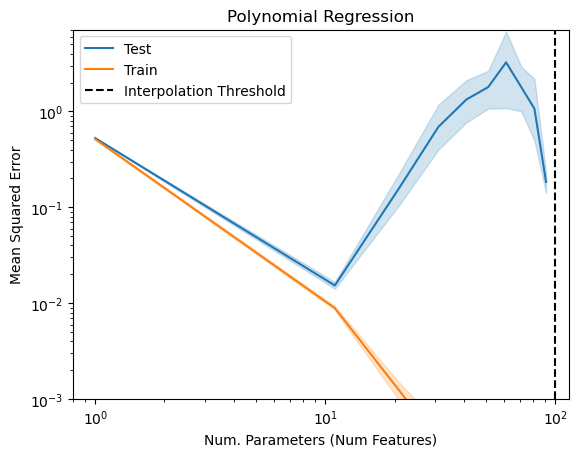

In [33]:
#@title Performing linear fits on computed data, with regularisation and repeats. Does not print out every step.

# Set seed for reproducibility.
np.random.seed(0)

num_data_list = [100]
#num_features_list = [1,5,10,14,15,16,20,50, 60, 70,100,200]
#num_features_list = np.linspace(start=13, stop=17, num=10)
num_features_list = np.arange(1, 100, 10, dtype=int)
num_repeat_list = list(range(50))

# Create sklearn linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)


#def compute_y_from_x(X: np.ndarray):
    #return np.add(2.0 * X, np.cos(X * 25))[:, 0] #the function being fit to
    #return np.add(2.0 * X, np.square(np.cos(X*25)))[:, 0] #squared cosine, which seems to dramatically change the character of the behaivour at the interpolation threshold
#    return np.add(2.0 * X, 0.5 * np.power(np.cos(X*25) , 10))[:, 0] #raising cosine to the 10th power to give very spikey function
def compute_y_from_x(X: np.ndarray):
    return compute_y_from_x_cos_simple(X)

low, high = -1.0, 1.0
for num_data in num_data_list:
    mse_list = []
    #results_num_data_dir = os.path.join(results_dir, f"num_data={num_data}")
    #os.makedirs(results_num_data_dir, exist_ok=True)

    # Generate test data.
    X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
    y_test = compute_y_from_x(X_test)

    # Plot the data.
    '''
    plt.close()
    sns.lineplot(x=X_test[:, 0], y=y_test, label="True Function")
    # sns.scatterplot(x=X_train[:, 0], y=y_train, s=30, color='k', label='Data')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.close()
    '''

    for num_features in tqdm(num_features_list):
        feature_degrees = 1 + np.arange(num_features).astype(int)
        #print(f"feature degrees = ", feature_degrees)
        #print(
        #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
        #)
        for repeat_idx in num_repeat_list:
            # Sample training data.
            X_train = np.random.uniform(low=low, high=high, size=(num_data, 1))
            y_train = compute_y_from_x(X_train)

            # Fit a polynomial regression model.
            X_train_poly = scipy.special.eval_legendre(feature_degrees, X_train)
            X_test_poly = scipy.special.eval_legendre(feature_degrees, X_test)
            beta_hat = np.linalg.pinv(X_train_poly) @ y_train
            y_train_pred = X_train_poly @ beta_hat
            y_test_pred = X_test_poly @ beta_hat
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            mse_list.append(
                {
                    "Num. Data": num_data,
                    "Num. Parameters (Num Features)": num_features,
                    "repeat_idx": repeat_idx,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                }
            )
            #print(
            #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
            #)

    mse_df = pd.DataFrame(mse_list)
    #mse_df[(np.abs(stats.zscore(mse_df)) < 3).all(axis=1)]
    mse_df = mse_df[(np.abs(stats.zscore(mse_df['Test MSE'])) < 2).to_frame().all(axis=1)] #has more agressive and effective outlier clearing
    plt.close()
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Test MSE",
        label="Test",
    )
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Train MSE",
        label="Train",
    )
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=1e-3)
    plt.yscale("log")
    plt.xscale("log")
    plt.title("Polynomial Regression")
    plt.axvline(
        x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
    )
    plt.legend()
    plt.show()


C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

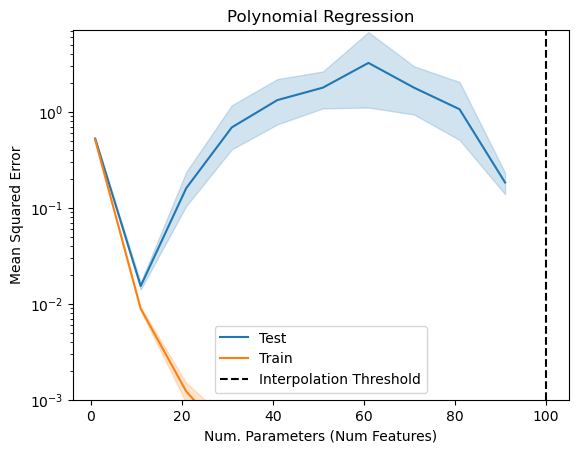

In [34]:
    plt.close()
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Test MSE",
        label="Test",
    )
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Train MSE",
        label="Train",
    )
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=1e-3)
    plt.yscale("log")
    #plt.xscale("log")
    plt.title("Polynomial Regression")
    plt.axvline(
        x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
    )
    plt.legend()
    plt.show()

C:\Users\plogo\AppData\Local\Temp\ipykernel_8348\231649892.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)
  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a futur

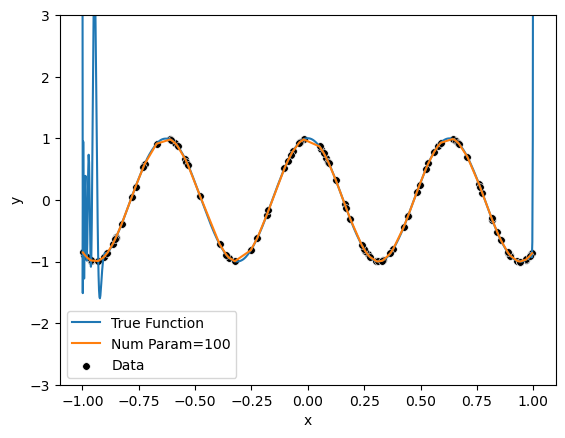

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


In [37]:
# For plotting a single polynomial fit. Plot the polynomial fit data. Note that this must have properly defined regression beforehand. ###UNTESTED

num_data = 100
num_features = 100
num_repeat_list = list(range(1))
# Create sklearn linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)

pd.set_option('mode.use_inf_as_na', True)


#def compute_y_from_x_plot(X: np.ndarray):
#    y = np.add(np.power(np.cos(X * 15), 2), np.cos(X * 25))[:, 0]
#return y

def compute_y_from_x_plot(X: np.ndarray):
    return compute_y_from_x_cos_simple(X)

'''
def compute_y_from_x_plot(X: np.ndarray):
    noise_strength=5
    y = 5*np.cos(X * 25) + 5*np.cos(X *15) #calculate y to have two frequencies
    noise = np.empty(np.shape(y)) #initialise brownian noise term
    noise[0] = 0 #initialising the first value of the brownian noise array to be 0
    rng = np.random.default_rng() #initialising np random. Gives a float between 0 and 1, uniformly
    for index, val in enumerate(noise[1:]):
        if rng.random() < 0.5: #50/50 chance of subtracting noise_strength term to previous value in list
            noise[index] = noise[index-1] - noise_strength #subtracting noise_strength
        if rng.random() > 0.5: #50/50 chance of adding noise_strength term to previous value in list
            noise[index] = noise[index-1] + noise_strength #adding noise_strength
    y_noisy = y + noise
    return y_noisy
'''
low, high = -1.0, 1.0
mse_list = []
# Generate test data.
X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
y_test = compute_y_from_x_plot(X_test)
'''
# Plot the data.
plt.close()
sns.lineplot(x=X_test[:, 0], y=y_test, label="True Function")
# sns.scatterplot(x=X_train[:, 0], y=y_train, s=30, color='k', label='Data')
plt.xlabel("x")
plt.ylabel("y")
plt.show()
#plt.close()
'''
feature_degrees = 1 + np.arange(num_features).astype(int)
for repeat_idx in tqdm(num_repeat_list):
    # Sample training data.
    X_train = np.random.uniform(low=low, high=high, size=(num_data, 1))
    y_train = compute_y_from_x_plot(X_train)

    # Fit a polynomial regression model.
    X_train_poly = scipy.special.eval_legendre(feature_degrees, X_train)
    X_test_poly = scipy.special.eval_legendre(feature_degrees, X_test)
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    y_train_pred = X_train_poly @ beta_hat
    y_test_pred = X_test_poly @ beta_hat
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    mse_list.append(
        {
            "Num. Data": num_data,
            "Num. Parameters (Num Features)": num_features,
            "repeat_idx": repeat_idx,
            "Train MSE": train_mse,
            "Test MSE": test_mse,
        }
    )
    #print(
    #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
    #)

    # Plot the polynomial fit data.
    plt.close()
    #print(np.array(X_test[:, 0]))
    #print(np.array(y_test.flatten()))
    sns.lineplot(x=X_test[:, 0].reshape(-1,), y=y_test_pred.reshape(-1,), label="True Function, f(x) = cos(10x)")
    sns.lineplot(
        x=X_train[:, 0].reshape(-1,),
        y=y_train.reshape(-1,),
        label=f"Num Param={X_train_poly.shape[1]}",
    )
    sns.scatterplot(x=X_train[:, 0].reshape(-1,), y=y_train.reshape(-1,), s=30, color="k", label="Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-3, 3)
    #for extension in ["pdf", "png"]:
    #    plt.savefig(
    #        os.path.join(
    #            results_num_features_dir, f"repeat_idx={repeat_idx}.{extension}"
    #        ),
    #        bbox_inches="tight",
    #        dpi=300,
    #    )
    plt.show()
    #plt.close()


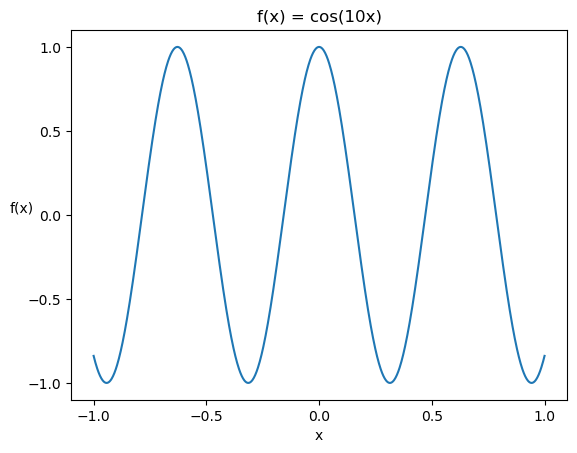

In [32]:
# Plotting the function being fit

X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
Y_test = compute_y_from_x_cos_simple(X_test)

plt.xlabel('x')
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.ylabel('f(x)', rotation=0)
plt.yticks(np.arange(-1, 1.5, 0.5))
plt.title('f(x) = cos(10x)')
plt.plot(X_test, Y_test)